In [1]:
import os 
import re

import pyedflib
import numpy as np 
import matplotlib.pyplot as plt

import skfda
import skfda.representation.basis as basis
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

from skfda.representation.basis import BSplineBasis
from skfda.representation.interpolation import SplineInterpolation
from scipy import stats 
from scipy.special import exp10 as exp10

#NOTE: dataset needs to be downloaded and unziped  

#filter edf files
eeg_signalfiles_names = list(filter(lambda s : s.endswith(".edf") , 
                            [os.path.abspath(os.path.join("../data/eeg-during-mental-arithmetic-tasks-1.0.0", f)) for 
                            f in os.listdir("../data/eeg-during-mental-arithmetic-tasks-1.0.0")]
                        ))

#dicts with subject_id - eeg_signal_filepath
before_arith_task = {}
after_arith_task = {}

# process each file
for edf_file_name in eeg_signalfiles_names :
    file_name = os.path.basename(edf_file_name)
    
    # extract subject identifier and suffix
    if "_1.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        before_arith_task[subject_id] = edf_file_name
    
    elif "_2.edf" in file_name:
        subject_id = int(re.findall(r"\d\d", file_name)[0])
        after_arith_task[subject_id] = edf_file_name

In [2]:
print("len of dict bat: ",len(before_arith_task.keys()))
print("len of dict aat: ",len(after_arith_task.keys()))

len of dict bat:  36
len of dict aat:  36


In [3]:
label_index_dict = {"Fp1":0,"Fp2":1,"F3":2,"F4":3,"F7":4,"F8":5,"T3":6,"T4":7,"C3":8,
                    "C4":9,"T5":10,"T6":11,"P3":12,"P4":13,"O1":14,"O2":15,"Fz":16, "Cz":17,"Pz":18}

In [4]:
f = pyedflib.EdfReader(before_arith_task[1])
#print edf file metadata
print(f.file_info_long())
eeg_signal = f.readSignal(label_index_dict.get("T4", None))
fs = f.getSampleFrequencies()
num_samples = f.getNSamples()

f.close()
print("fs: ", fs)
print("num samples: ", num_samples)
print("eeg signal number 0: ", eeg_signal)

file name: /home/enki/Documents/THESIS/FDA-EEG/data/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf
signals in file: 21
label: EEG Fp1 fs: 500.0 nsamples 91000
label: EEG Fp2 fs: 500.0 nsamples 91000
label: EEG F3 fs: 500.0 nsamples 91000
label: EEG F4 fs: 500.0 nsamples 91000
label: EEG F7 fs: 500.0 nsamples 91000
label: EEG F8 fs: 500.0 nsamples 91000
label: EEG T3 fs: 500.0 nsamples 91000
label: EEG T4 fs: 500.0 nsamples 91000
label: EEG C3 fs: 500.0 nsamples 91000
label: EEG C4 fs: 500.0 nsamples 91000
label: EEG T5 fs: 500.0 nsamples 91000
label: EEG T6 fs: 500.0 nsamples 91000
label: EEG P3 fs: 500.0 nsamples 91000
label: EEG P4 fs: 500.0 nsamples 91000
label: EEG O1 fs: 500.0 nsamples 91000
label: EEG O2 fs: 500.0 nsamples 91000
label: EEG Fz fs: 500.0 nsamples 91000
label: EEG Cz fs: 500.0 nsamples 91000
label: EEG Pz fs: 500.0 nsamples 91000
label: EEG A2-A1 fs: 500.0 nsamples 91000
label: ECG ECG fs: 500.0 nsamples 91000
None
fs:  [500. 500. 500. 500. 500. 500. 500. 

In [5]:
def eeg_data_matrix(subject_idx, subject_edfsignal_dict, labels):
    if subject_edfsignal_dict.get(subject_idx,-1) == -1:
        raise KeyError
    #build data matrix
    with pyedflib.EdfReader(subject_edfsignal_dict[subject_idx]) as f:
        eeg_signals_arr = []
        for label in labels:
            idx = label_index_dict.get(label,-1)
            if idx == -1:
               raise KeyError
            eeg_signal = f.readSignal(idx)
            eeg_signals_arr.append(eeg_signal)
        f.close()
        return np.matrix(eeg_signals_arr)

In [6]:
all_labels = list(label_index_dict.keys())
data = eeg_data_matrix(1, before_arith_task, all_labels)
print("data : ", data)

data :  [[-6.34791221e+00 -5.88470922e+00 -5.16095454e+00 ...  1.39021195e-03
   1.39021195e-03  1.39021195e-03]
 [-6.71995401e+00 -6.25268698e+00 -5.50295629e+00 ...  5.77824979e-04
   5.77824979e-04  5.77824979e-04]
 [-5.61789152e+00 -5.75924681e+00 -5.68246122e+00 ...  1.41752346e-03
   1.41752346e-03  1.41752346e-03]
 ...
 [-3.57152858e+00 -3.90513513e+00 -4.15791191e+00 ... -3.21821012e-04
  -3.21821012e-04 -3.21821012e-04]
 [-5.23125354e+00 -6.30394179e+00 -7.29497765e+00 ... -6.97556420e-04
  -6.97556420e-04 -6.97556420e-04]
 [-6.41279333e+00 -6.48198043e+00 -6.30901266e+00 ...  1.84008240e-03
   1.84008240e-03  1.84008240e-03]]


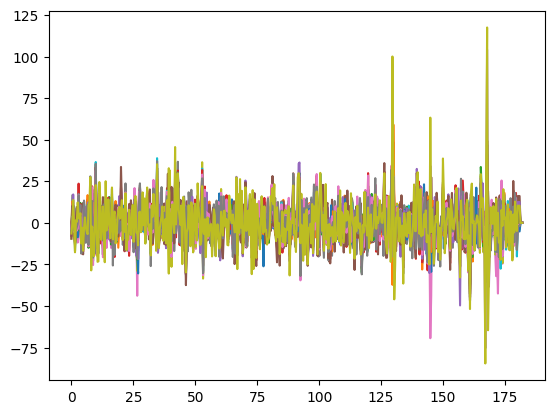

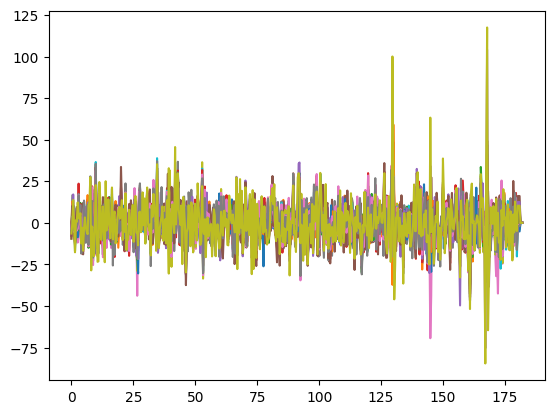

In [7]:
#raw eeg-signals transformed into discrete functional data using 
#B-splines basis functions

fd = skfda.FDataGrid(
            data_matrix=data,
            grid_points=np.linspace(0,num_samples[0],num_samples[0])/fs[0]
        )
n_basis = 19

fd.plot()

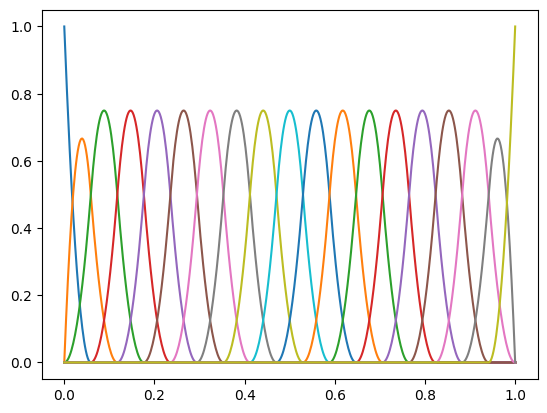

In [8]:
#plot b-spline basis
bspline_basis = skfda.representation.basis.BSplineBasis(n_basis=n_basis, order=3)
bspline_basis.plot()
plt.show()

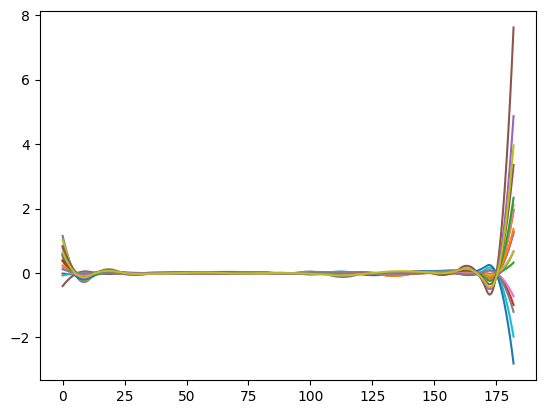

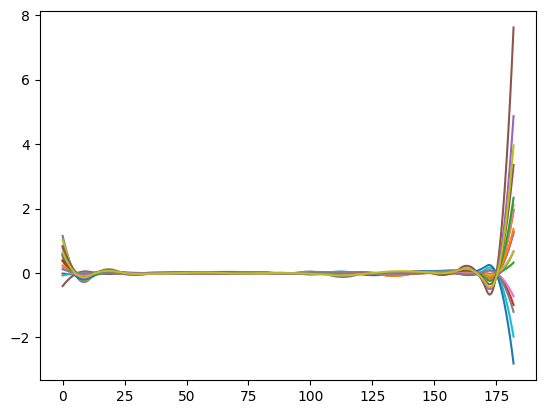

In [9]:
#plot of discrete functional data transformed into truncated basis-functions format using
#B-splines basis functions
fd_basis = fd.to_basis(basis.BSplineBasis(n_basis=n_basis, order=3))

fd_basis.plot()

eigvals vals:  [1.95324864e+02 4.60020155e+00 3.23725915e-01 2.32261804e-01
 2.06323491e-01 4.68409477e-02 3.79898407e-02 2.48410379e-02
 1.78104769e-02 8.77523545e-03 5.38359411e-03 3.10394117e-03
 9.55369837e-04 1.14700060e-04 3.34760700e-05 1.12996777e-05
 3.29815718e-06 1.92205204e-06]


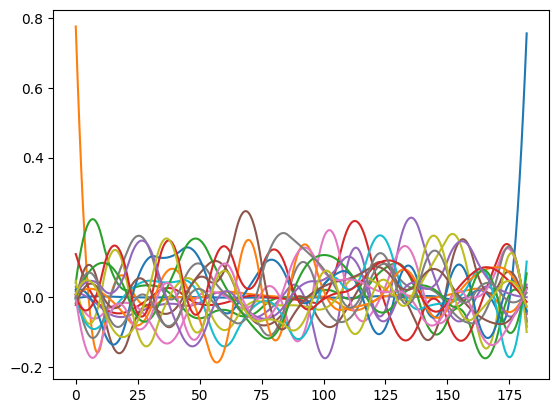

In [10]:
#plot of the first 19 principal components and its associated eigvals
fpca = FPCA(n_basis)
fpca.fit(fd_basis)
fpca.components_.plot()

eigvals = np.square(fpca.singular_values_)
eigvals = eigvals[np.abs(eigvals) >= np.finfo(float).eps] #filter eigvals less than machine epsilon

print("eigvals vals: ", eigvals)

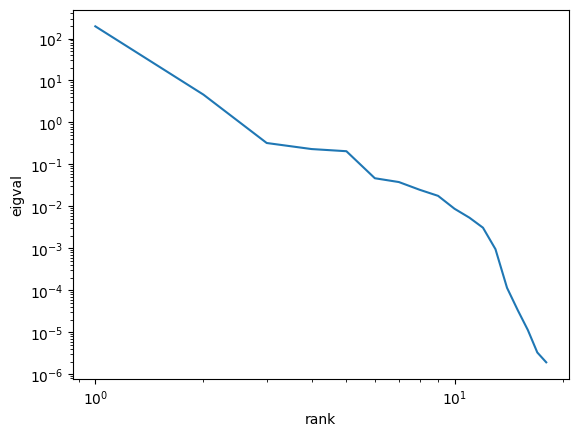

In [11]:
#ranks vs eigspectrum in loglog scale
ranks = np.linspace(1,len(eigvals),len(eigvals))
plt.loglog(ranks, eigvals)

#label axes
plt.xlabel('rank')
plt.ylabel('eigval')

#show plot
plt.show()

r**2:  0.8729680884427892


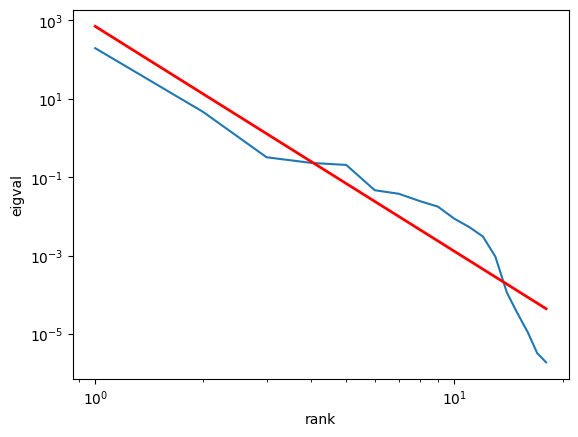

In [12]:
#slope, intercept
slope, intercept, r, p, se = stats.linregress(np.log10(ranks), 
    np.log10(eigvals))

print("r**2: ", r**2)

power_law = lambda x: 10**(intercept + np.log10(x)*slope)

vals = list(map(power_law, ranks))

ranks = np.linspace(1,len(eigvals),len(eigvals))
plt.loglog(ranks, eigvals)
plt.plot(ranks, vals, label=f'Fit: y = {10**intercept:.2f} * x^{slope:.2f}', color='red', linewidth=2)

#label axes
plt.xlabel('rank')
plt.ylabel('eigval')

#show plot
plt.show()

In [13]:
#auxiliary functions to perform KS test
def cumulative_eigval(x): 
    x_index = np.argmax(eigvals == x)
    return np.sum(eigvals[:x_index])/np.sum(eigvals)

truncated_zeta = lambda s,N: np.sum(1/(ranks[:N]**s))

def power_law_cdf(x): 
    values = []
    cdf_eigvals = list(map(cumulative_eigval, eigvals))
    for value in x:
        values.append(truncated_zeta(slope, np.argmax(cdf_eigvals == value))/truncated_zeta(slope,len(ranks)))
        
    return np.array(values)

In [14]:
cdf_eigvals = list(map(cumulative_eigval, eigvals))
print(cdf_eigvals)

print(power_law_cdf(cdf_eigvals))

#KS test
KS_test_results = stats.kstest(np.log(eigvals), power_law_cdf)

print("KS test pval: ", KS_test_results.pvalue)

[0.0, 0.9725723797160628, 0.9954779580254666, 0.9970898720290294, 0.9982463628653863, 0.9992737002178848, 0.9995069332587726, 0.9996960943775353, 0.9998197842491824, 0.9999084671620702, 0.9999521613003691, 0.999978967590296, 0.9999944229060722, 0.9999991799364715, 0.9999997510573629, 0.9999999177432642, 0.9999999740072453, 0.9999999904296121]
[0.00000000e+00 1.98511000e-08 1.07603528e-06 1.18744165e-05
 6.80690362e-05 2.70058245e-04 8.44589601e-04 2.23503220e-03
 5.22488506e-03 1.10988687e-02 2.18457697e-02 4.04070595e-02
 7.09751856e-02 1.19345321e-01 1.93324268e-01 3.03200118e-01
 4.62276203e-01 6.87472804e-01]
KS test pval:  0.0
